# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

#### Used cars are a big business and many factors go in to what makes one used car more or less valuable than other used cars.  In order to maximize profits a used car dealership will need to have an inventory of cars with desired features at a competitive price.  Therefore, it is imperative that the used car dealership has the appropriate data and projections to be able to create adequate inventory with the competitive prices.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

### The first step is to look at the dataset and see what can be gleaned.  The dataset being used contains detailed information about hundreds of thousands of used car sales. From this dataset we can begin to ask some important questions to help us better understand the data.
### Questions to answer:
### Are there features that have a strong correlation  or no correlation with price?
### Unfortunately the data has few ‘continuous’ values to begin with. This will be addressed below.  With the only continuous values being id, price, year, and odometer reading very little was gleaned. With that said there appears to be little correlation with id and some correlation with odometer.
### Are there features with exclusively one particular value?
### Title_status is almost exclusively ‘clean’. Possibly drop this column since it likely can’t provide meaning.
### Are there features with missing values?
### Some columns have many missing values and these will need to be addressed on a case by case basis.  In some cases if there are not many missing values they might be dropped from the dataset.
### Are there categorical features that need to be encoded?
### This dataset has many categorical features; some of them will need to be one-hot encoded(ie Fuel), while other might be converted to ordinal values(ie Condition). Some of the categorical features with many different values might have to be addressed in a more unique way on a case by case basis.
### Looking at the data the biggest question remains that price does not necessarily equate with profits. It would be helpful to collect data on the price the dealers purchased the cars for to be able to see which cars produced more profits. 


### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [1]:
import pandas as pd
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.linear_model import LogisticRegression, LinearRegression , Lasso, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel, RFE
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
pd.set_option('display.max_columns', None)
from sklearn.inspection import permutation_importance
from numpy import arange
from pandas import read_csv
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold

### Import and examine the data

In [2]:
cars = pd.read_csv('data/vehicles.csv')
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [3]:
cars.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [4]:
cars.describe()
cars.corr()

,id,price,year,odometer
id,1.000000,-0.002779,-0.059040,0.010721
price,-0.002779,1.000000,-0.004925,0.010032
year,-0.059040,-0.004925,1.000000,-0.157215
odometer,0.010721,0.010032,-0.157215,1.000000


In [5]:
n = cars.nunique(axis=0)
print("No.of.unique values in each column :\n",
      n)

No.of.unique values in each column :
 id              426880
region             404
price            15655
year               114
manufacturer        42
model            29649
condition            6
cylinders            8
fuel                 5
odometer        104870
title_status         6
transmission         3
VIN             118246
drive                3
size                 4
type                13
paint_color         12
state               51
dtype: int64


In [6]:
cars['paint_color'].unique()

array([nan, 'white', 'blue', 'red', 'black', 'silver', 'grey', 'brown',
       'yellow', 'orange', 'green', 'custom', 'purple'], dtype=object)

In [7]:
cars['region'].value_counts()

columbus                   3608
jacksonville               3562
spokane / coeur d'alene    2988
eugene                     2985
fresno / madera            2983
                           ... 
meridian                     28
southwest MS                 14
kansas city                  11
fort smith, AR                9
west virginia (old)           8
Name: region, Length: 404, dtype: int64

### drop and fill missing values

In [8]:
cars.drop(columns = ['id', 'title_status', 'VIN', 'model', 'size', 'region'], inplace = True )
cars['manufacturer'].dropna(inplace = True)
cars['year'].fillna(cars['year'].median(), inplace = True)
#need to convert condition to ordinal and then fill missing with mean or median
# cylinders...convert to number and then fill with. mean or median
cars['fuel'].fillna(cars['fuel'].value_counts().index[0], inplace = True)
cars['odometer'].fillna(cars['odometer'].mean(), inplace = True)
cars['transmission'].fillna(cars['transmission'].value_counts().index[0], inplace = True)
# drive....what to do with missing...need to ohe 
# type....labels....missing?
cars['paint_color'].fillna(cars['paint_color'].value_counts().index[0], inplace = True)
cars = cars[cars['cylinders'] != 'other']
cars['cylinders'].fillna(0, inplace = True)
cars = cars[cars['drive'].notna()]
cars = cars[cars['manufacturer'].notna()]
cars = cars[cars['type'].notna()]
cars.drop(cars[cars['price'] == 0].index, inplace = True)
cars.drop(cars[cars['price'] > 100000].index, inplace = True)

In [9]:
cars.drop(cars[cars['year'] < 1990].index, inplace = True)
cars.drop(cars[cars['odometer'] > 200000].index, inplace = True)
cars.dropna(inplace = True)

In [10]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144871 entries, 31 to 426879
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         144871 non-null  int64  
 1   year          144871 non-null  float64
 2   manufacturer  144871 non-null  object 
 3   condition     144871 non-null  object 
 4   cylinders     144871 non-null  object 
 5   fuel          144871 non-null  object 
 6   odometer      144871 non-null  float64
 7   transmission  144871 non-null  object 
 8   drive         144871 non-null  object 
 9   type          144871 non-null  object 
 10  paint_color   144871 non-null  object 
 11  state         144871 non-null  object 
dtypes: float64(2), int64(1), object(9)
memory usage: 14.4+ MB


In [11]:
## replace cylinders with numbers
cars['cylinders'] = cars['cylinders'].replace(['0'], 0)
cars['cylinders'] = cars['cylinders'].replace(['3 cylinders'], 3)
cars['cylinders'] = cars['cylinders'].replace(['4 cylinders'], 4)
cars['cylinders'] = cars['cylinders'].replace(['5 cylinders'], 5)
cars['cylinders'] = cars['cylinders'].replace(['6 cylinders'], 6)
cars['cylinders'] = cars['cylinders'].replace(['8 cylinders'], 8)
cars['cylinders'] = cars['cylinders'].replace(['10 cylinders'], 10)
cars['cylinders'] = cars['cylinders'].replace(['12 cylinders'], 12)
cars.loc[cars['cylinders'] == 0  , 'cylinders'] = 6
cars['cylinders'].unique()
cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144871 entries, 31 to 426879
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         144871 non-null  int64  
 1   year          144871 non-null  float64
 2   manufacturer  144871 non-null  object 
 3   condition     144871 non-null  object 
 4   cylinders     144871 non-null  int64  
 5   fuel          144871 non-null  object 
 6   odometer      144871 non-null  float64
 7   transmission  144871 non-null  object 
 8   drive         144871 non-null  object 
 9   type          144871 non-null  object 
 10  paint_color   144871 non-null  object 
 11  state         144871 non-null  object 
dtypes: float64(2), int64(2), object(8)
memory usage: 14.4+ MB


In [12]:
# take a random sample from dataset and make a plot
cars3 = cars[['price', 'year', 'odometer']]
cars_sample = cars3.sample(n = 100, random_state = 1)
cars_sample.head()

,price,year,odometer
194594,18995,2017.0,43406.0
145771,19995,2013.0,145207.0
175158,17990,2017.0,20909.0
52019,11338,2014.0,101905.0
166818,22999,2007.0,80466.0


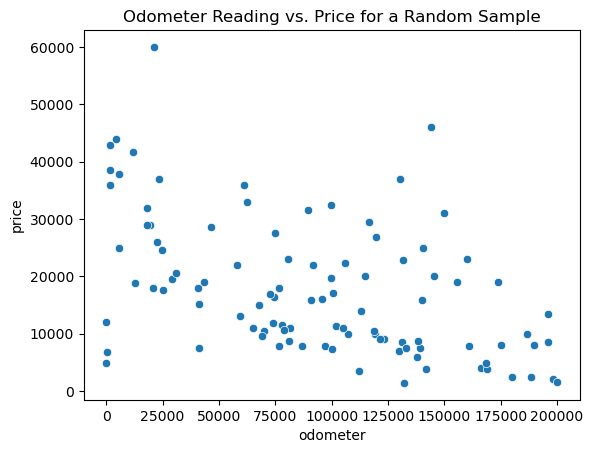

In [13]:
sns.scatterplot(x = 'odometer', y = 'price', data = cars_sample)
plt.title("Odometer Reading vs. Price for a Random Sample")
plt.show()

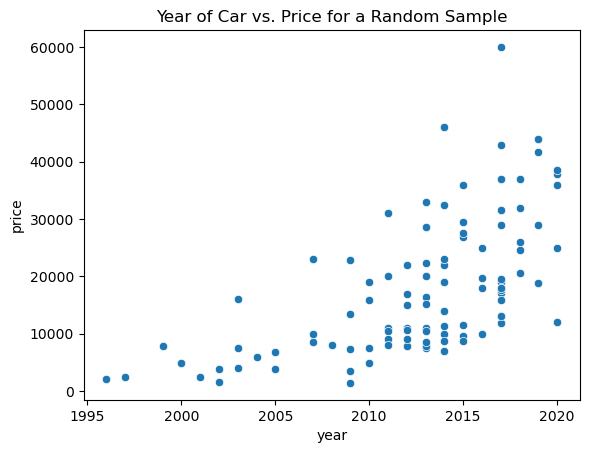

In [14]:
sns.scatterplot(x = 'year', y = 'price', data = cars_sample)
plt.title("Year of Car vs. Price for a Random Sample")
plt.show()

In [15]:
numeric_cols = ['price', 'year', 'odometer']
categorical_ohe = ['fuel', 'transmission', 'drive', 'paint_color', 'state']
categorical_ordinal = ['condition', 'cylinders', 'size',  ]
# Still to address: region, manufacturer, type, 

In [31]:
# Ordinal Encoding for Condition Feature
# condition = ['salvage', 'fair', 'good', 'excellent', 'like new', 'new']
# enc = OrdinalEncoder(categories = [condition], dtype = object)
# cars['condition'] = enc.fit_transform(cars[['condition']])
cars.head()
cars['condition'] = cars['condition'].astype(int)
cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144871 entries, 31 to 426879
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         144871 non-null  int64  
 1   year          144871 non-null  float64
 2   manufacturer  144871 non-null  object 
 3   condition     144871 non-null  int64  
 4   cylinders     144871 non-null  int64  
 5   fuel          144871 non-null  object 
 6   odometer      144871 non-null  float64
 7   transmission  144871 non-null  object 
 8   drive         144871 non-null  object 
 9   type          144871 non-null  object 
 10  paint_color   144871 non-null  object 
 11  state         144871 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 14.4+ MB


In [36]:
## Decision made to only create dummy columns for features with minimal unique values. 
cars2 = pd.get_dummies(cars,columns = ['fuel', 'transmission', 'drive'])
cars2 = cars2.reset_index()
cars2.info(verbose = True)
cars2.drop(columns = 'index', inplace= True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144871 entries, 0 to 144870
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   index                   144871 non-null  int64  
 1   price                   144871 non-null  int64  
 2   year                    144871 non-null  float64
 3   manufacturer            144871 non-null  object 
 4   condition               144871 non-null  int64  
 5   cylinders               144871 non-null  int64  
 6   odometer                144871 non-null  float64
 7   type                    144871 non-null  object 
 8   paint_color             144871 non-null  object 
 9   state                   144871 non-null  object 
 10  fuel_diesel             144871 non-null  uint8  
 11  fuel_electric           144871 non-null  uint8  
 12  fuel_gas                144871 non-null  uint8  
 13  fuel_hybrid             144871 non-null  uint8  
 14  fuel_other          

In [39]:
# Label encode columns with many unique values.  This is less than ideal but necessary without far more time and computing power.
from sklearn.preprocessing import LabelEncoder
labeled_cols = ['manufacturer', 'paint_color', 'state', 'type']
cars2[labeled_cols] = cars2[labeled_cols].apply(LabelEncoder().fit_transform)
cars2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144871 entries, 0 to 144870
Data columns (total 20 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   price                   144871 non-null  int64  
 1   year                    144871 non-null  float64
 2   manufacturer            144871 non-null  int64  
 3   condition               144871 non-null  int64  
 4   cylinders               144871 non-null  int64  
 5   odometer                144871 non-null  float64
 6   type                    144871 non-null  int64  
 7   paint_color             144871 non-null  int64  
 8   state                   144871 non-null  int64  
 9   fuel_diesel             144871 non-null  uint8  
 10  fuel_electric           144871 non-null  uint8  
 11  fuel_gas                144871 non-null  uint8  
 12  fuel_hybrid             144871 non-null  uint8  
 13  fuel_other              144871 non-null  uint8  
 14  transmission_automat

# Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.



In [40]:
# Features and Target
features = cars2.drop(columns = ['price'])
# features = cars[['condition', 'odometer', 'cylinders', 'year']]
features.head()
price = cars2.price
price.head()

0    15000
1    27990
2    34590
3    35000
4    29990
Name: price, dtype: int64

In [41]:
cars2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144871 entries, 0 to 144870
Data columns (total 20 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   price                   144871 non-null  int64  
 1   year                    144871 non-null  float64
 2   manufacturer            144871 non-null  int64  
 3   condition               144871 non-null  int64  
 4   cylinders               144871 non-null  int64  
 5   odometer                144871 non-null  float64
 6   type                    144871 non-null  int64  
 7   paint_color             144871 non-null  int64  
 8   state                   144871 non-null  int64  
 9   fuel_diesel             144871 non-null  uint8  
 10  fuel_electric           144871 non-null  uint8  
 11  fuel_gas                144871 non-null  uint8  
 12  fuel_hybrid             144871 non-null  uint8  
 13  fuel_other              144871 non-null  uint8  
 14  transmission_automat

In [42]:
#scale the data
object = StandardScaler()
features_scaled = pd.DataFrame(object.fit_transform(features), columns = features.columns)
print(type(features))
print(type(features_scaled))


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


## Linear Regression

In [43]:
cars2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144871 entries, 0 to 144870
Data columns (total 20 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   price                   144871 non-null  int64  
 1   year                    144871 non-null  float64
 2   manufacturer            144871 non-null  int64  
 3   condition               144871 non-null  int64  
 4   cylinders               144871 non-null  int64  
 5   odometer                144871 non-null  float64
 6   type                    144871 non-null  int64  
 7   paint_color             144871 non-null  int64  
 8   state                   144871 non-null  int64  
 9   fuel_diesel             144871 non-null  uint8  
 10  fuel_electric           144871 non-null  uint8  
 11  fuel_gas                144871 non-null  uint8  
 12  fuel_hybrid             144871 non-null  uint8  
 13  fuel_other              144871 non-null  uint8  
 14  transmission_automat

In [46]:
# Start with a simple Linear Regression Model with just 2 features
features2 = cars2[['odometer', 'year']]
price = cars2['price']
f2 = LinearRegression(fit_intercept = True)
f2.fit(features2, price)
linreg_mse = mean_squared_error(f2.predict(features2), price)
print(linreg_mse)

98884090.80131193


Somewhat shocked by the high MSE value.

In [47]:
# checking the correlation between price and other features
pd.set_option('display.max_rows', 200)
price_corr = cars2.corrwith(cars2['price'])
print(price_corr)

price                     1.000000
year                      0.573961
manufacturer             -0.048122
condition                -0.058223
cylinders                 0.346602
odometer                 -0.579189
type                      0.044952
paint_color               0.042844
state                    -0.015047
fuel_diesel               0.230155
fuel_electric             0.050186
fuel_gas                 -0.284035
fuel_hybrid              -0.033247
fuel_other                0.198862
transmission_automatic   -0.345712
transmission_manual      -0.083239
transmission_other        0.412731
drive_4wd                 0.205704
drive_fwd                -0.326374
drive_rwd                 0.143142
dtype: float64


There appears to be relatively strong correlations between price with they year, the odometer reading, and 4 wheel drive.  Gas vehicles and front wheel drive vehicles seem to have a negative impact on price.  Somewhat surprisingly there does not seem to be much correlation with manufacturer. 

## Cross Validation

In [48]:
# Create testing and training data
X = features_scaled
y = price
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=22)
print(type(X))

<class 'pandas.core.frame.DataFrame'>


In [49]:
#Simple Linear Regrssion Model
lr = LinearRegression().fit(X_train, y_train)
model_1_train_mse = mean_squared_error(y_train, lr.predict(X_train))
model_1_test_mse = mean_squared_error(y_test, lr.predict(X_test))
print(f'Train MSE: {model_1_train_mse: .2f}')
print(f'Test MSE: {model_1_test_mse: .2f}')

Train MSE:  60255011.98
Test MSE:  61419623.65


In [50]:
print(list(zip(lr.coef_, X)))

[(5075.979558608593, 'year'), (244.29791293351582, 'manufacturer'), (243.3347003549243, 'condition'), (2983.989351987217, 'cylinders'), (-3929.2108789637646, 'odometer'), (47.485634818951695, 'type'), (-18.28899280466335, 'paint_color'), (-150.78176574600724, 'state'), (-319180374982549.4, 'fuel_diesel'), (-116545164111708.02, 'fuel_electric'), (-527162585576752.94, 'fuel_gas'), (-195329133235736.66, 'fuel_hybrid'), (-386785500662740.94, 'fuel_other'), (-3279248312313101.5, 'transmission_automatic'), (-1589955174398825.2, 'transmission_manual'), (-3067424889242559.0, 'transmission_other'), (2616749157141538.5, 'drive_4wd'), (2600995975591381.5, 'drive_fwd'), (2170026217938586.8, 'drive_rwd')]


In [51]:
# Examining the coefficients
coef_table = pd.DataFrame(list(X_train.columns)).copy()
coef_table.insert(len(coef_table.columns),"Coefs",lr.coef_.transpose())
coef_table.sort_values('Coefs')

,0,Coefs
13,transmission_automatic,-3.279248e+15
15,transmission_other,-3.067425e+15
14,transmission_manual,-1.589955e+15
10,fuel_gas,-5.271626e+14
12,fuel_other,-3.867855e+14
8,fuel_diesel,-3.191804e+14
11,fuel_hybrid,-1.953291e+14
9,fuel_electric,-1.165452e+14
4,odometer,-3.929211e+03
7,state,-1.507818e+02


Automatic transmission, 4wd, and electric vehicles are most influential in each of those categories.

In [52]:
r = permutation_importance(lr, X_test, y_test , n_repeats=30,random_state=0)
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X.columns[i]:<8}"
        f"  {r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")


transmission_automatic  127145682696618750509056.000 +/- 587296989202378981376.000
transmission_other  111290421674644938424320.000 +/- 412367420356559175680.000
drive_4wd  81271982462565009588224.000 +/- 407410271306641833984.000
drive_fwd  80522005440422643499008.000 +/- 395746594671873753088.000
drive_rwd  56034516332976795549696.000 +/- 285330042943163957248.000
transmission_manual  29401618848816090316800.000 +/- 137236243498075668480.000
fuel_gas  3311264715550646861824.000 +/- 17086692802070177792.000
fuel_other  1752063533032816771072.000 +/- 9418207021919367168.000
fuel_diesel  1247846162813400383488.000 +/- 5826960167722064896.000
fuel_hybrid  463404740183706238976.000 +/- 2322918581940332544.000
fuel_electric  152344478387652722688.000 +/- 568653085277027328.000
year      0.306 +/- 0.003
odometer  0.184 +/- 0.002
cylinders  0.106 +/- 0.001
manufacturer  0.001 +/- 0.000
condition  0.001 +/- 0.000
state     0.000 +/- 0.000
type      0.000 +/- 0.000


## Ridge Regression


In [53]:
ridge = Ridge(alpha = 1)
ridge.fit(X_train, y_train)
ridge_train_mse = mean_squared_error(y_train, ridge.predict(X_train))
ridge_test_mse = mean_squared_error(y_test, ridge.predict(X_test))
print(f'The Ridge training MSE is: {ridge_train_mse}')
print(f'The Ridge testing MSE is: {ridge_test_mse}')
# scores = cross_val_score(ridge_pipeline, X_train, y_train, cv = 5, scoring='neg_root_mean_squared_error')
# print(scores)
# print(f'Mean score of {scores.mean()} with a standard deviation of {scores.std()}')

The Ridge training MSE is: 60254993.5820269
The Ridge testing MSE is: 61419706.45462793


In [54]:
# Using GridSearch to find best alpha
parameters = {'alpha': [0.1, .5, 1, 5, 10]}
gd = GridSearchCV(ridge, parameters)
gd.fit(X_train, y_train)
gd.best_params_

{'alpha': 10}

In [55]:
# Try another Ridge model. 
ridge2 = Ridge()
cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state =1)
grid = dict()
grid['alpha'] = arange(0, 1, 0.01)
search = GridSearchCV(ridge2, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
results = search.fit(X_train, y_train)
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

/Users/leostern/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=3.48929e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


MAE: -5332.944
Config: {'alpha': 0.99}


With alpha 0 it seems that we are just using Linear Regression here.

In [56]:
r = permutation_importance(ridge, X_test, y_test , n_repeats=30,random_state=0)
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X.columns[i]:<8}"
        f"  {r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

year      0.305 +/- 0.003
odometer  0.184 +/- 0.002
cylinders  0.105 +/- 0.001
fuel_diesel  0.054 +/- 0.001
drive_fwd  0.042 +/- 0.001
drive_4wd  0.017 +/- 0.001
fuel_gas  0.011 +/- 0.000
drive_rwd  0.007 +/- 0.000
transmission_automatic  0.003 +/- 0.000
transmission_other  0.002 +/- 0.000
fuel_hybrid  0.002 +/- 0.000
transmission_manual  0.001 +/- 0.000
manufacturer  0.001 +/- 0.000
condition  0.001 +/- 0.000
fuel_other  0.001 +/- 0.000
state     0.000 +/- 0.000
type      0.000 +/- 0.000
fuel_electric  0.000 +/- 0.000


In [57]:
# Year and odometer readings appear to be the features that provide the most insight into price.

In [74]:
coef_table2 = pd.DataFrame(list(X_train.columns)).copy()
coef_table2.insert(len(coef_table2.columns),"Coefs",ridge.coef_.transpose())
coef_table.sort_values('Coefs')

,0,Coefs
13,transmission_automatic,-3.279248e+15
15,transmission_other,-3.067425e+15
14,transmission_manual,-1.589955e+15
10,fuel_gas,-5.271626e+14
12,fuel_other,-3.867855e+14
8,fuel_diesel,-3.191804e+14
11,fuel_hybrid,-1.953291e+14
9,fuel_electric,-1.165452e+14
4,odometer,-3.929211e+03
7,state,-1.507818e+02


## Feature Selection

In [65]:
rfe = RFE(estimator = LinearRegression(), n_features_to_select = 3)
rfe.fit(X_train, y_train)
print(rfe.support_)
print(rfe.ranking_)

[False False False False False False False False False False False False
 False  True  True  True False False False]
[10 14 13 12 11 16 17 15  5  9  6  7  8  1  1  1  3  2  4]


In [66]:
## Feature Selection Pipeline
selector_pipe = Pipeline([
    ('selector', SequentialFeatureSelector(LinearRegression())),
    ('model', LinearRegression())
])
selector_pipe
selector_pipe.fit(X_train, y_train)
param_dict = {'n_features_to_select' : [3, 5, 10]}

In [67]:
param_dict = {'selector__n_features_to_select': [3,5,10]} 
selector_grid = GridSearchCV(selector_pipe, param_grid=param_dict)
selector_grid.fit(X_train, y_train)
train_preds = selector_grid.predict(X_train)
test_preds = selector_grid.predict(X_test)
selector_train_mse = mean_squared_error(y_train, train_preds)
selector_test_mse = mean_squared_error(y_test, test_preds)
print(f'Train MSE: {selector_train_mse}')
print(f'Test MSE: {selector_test_mse}')
print(f'Best params: {selector_grid.best_params_}')

Train MSE: 60307536.81291765
Test MSE: 61485715.97012782
Best params: {'selector__n_features_to_select': 10}


In [68]:
r = permutation_importance(selector_pipe, X_test, y_test , n_repeats=30,random_state=0)
for i in r.importances_mean.argsort()[::-1]:
        print(f"{X.columns[i]:<8}"
        f"  {r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

year      0.309 +/- 0.003
odometer  0.179 +/- 0.002
drive_fwd  0.107 +/- 0.001
cylinders  0.104 +/- 0.001
fuel_diesel  0.090 +/- 0.001
transmission_automatic  0.012 +/- 0.000
fuel_other  0.003 +/- 0.000
manufacturer  0.001 +/- 0.000
condition  0.001 +/- 0.000
paint_color  0.000 +/- 0.000
type      0.000 +/- 0.000
drive_rwd  0.000 +/- 0.000
state     0.000 +/- 0.000
fuel_gas  0.000 +/- 0.000
fuel_hybrid  0.000 +/- 0.000
transmission_manual  0.000 +/- 0.000
transmission_other  0.000 +/- 0.000
drive_4wd  0.000 +/- 0.000
fuel_electric  0.000 +/- 0.000


### From this model it appears that once again the year and odometer have the most influence on price.


## Further Modeling
A few of the models seem to show that transmission, fuel, and drive are the most important features while another model showed odometer, year, and cylinders were more important. Let's try running Linear Regression models in these 2 cases.



### Linear Regression with transmission, fuel, and drive

In [75]:
features3 = cars2[['transmission_automatic', 'transmission_other', 'transmission_manual', 'fuel_gas', 'fuel_hybrid', 'drive_rwd', 'fuel_electric','fuel_other', 'drive_4wd','drive_fwd','fuel_diesel']]      
price2 = cars2.price

In [76]:
# Create testing and training data
X1 = features3
y1 = price2
X1_train, X1_test, y1_train, y1_test = train_test_split(X1,y1,test_size=0.3,random_state=22)

In [77]:
tfd_model = LinearRegression().fit(X1_train, y1_train)
model_1_train_mse = mean_squared_error(y1_train, tfd_model.predict(X1_train))
model_1_test_mse = mean_squared_error(y1_test, tfd_model.predict(X1_test))
print(f'Train MSE: {model_1_train_mse: .2f}')
print(f'Test MSE: {model_1_test_mse: .2f}')

Train MSE:  109713807.25
Test MSE:  111029792.72


### Linear Regression with Odometer, State, Manufacturer

In [84]:
features4 = cars2[['odometer', 'year', 'cylinders']]
price3 = cars2.price

In [85]:
# Create testing and training data
X2 = features4
y2 = price3
X2_train, X2_test, y2_train, y2_test = train_test_split(X2,y2,test_size=0.3,random_state=22)

In [86]:
osm_model = LinearRegression().fit(X2_train, y2_train)
model_1_train_mse = mean_squared_error(y2_train, osm_model.predict(X2_train))
model_1_test_mse = mean_squared_error(y2_test, osm_model.predict(X2_test))
print(f'Train MSE: {model_1_train_mse: .2f}')
print(f'Test MSE: {model_1_test_mse: .2f}')

Train MSE:  76317274.62
Test MSE:  77320113.39


Overall, it seems that the model focused on price, odometer reading, and number of cylinders has the greatest effect on the price of the vehicle.

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

Modeling was a bit more challenging than expected.  Since a few of the columns lended themselves to one hot encoding it created a dataframe with far too many columns than was able to be processed with a home laptop.  With this restriction in mind a dataframe that was limited to 20 columns with several of the columns labeled in a less than ideal manner. The modeling produced inconsistent results as the errors were rather large. Overall, it was apparent that the features that had the most positive  impact on price was the lower odometer readings, newer cars, and more cylinders.   Some other features seemed to also play a part.  While I could certainly recommend that automatic transmissions are recommended and preferred by buyers over other transmissions, I would not feel overly confident providing any other valuable insights with the data collected and analyzed thus far. I would recommend collecting more data that correlated more with price.  As we’ve seen from previous studies it might be possible to collect data on horsepower, fuel efficiency, or other metrics that might be  correlated better with price. Another fault of this whole process is that it’s unclear which types of cars provide the most profit vs. just which cars sell for the most.  This would be essential in making suggestions to used car dealers.  It might be possible that cheaper cars sell more frequently and provide more profit but it is hard to make that conclusion from the current data.


### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

pon collecting, organizing, and analyzing the data provided in order to give insight into how to maximize profits with the sale of used cars we can provide some insight but would also feel more comfortable collecting more data and providing further analysis. Most essentially, it would be very helpful to know the profits made on previous car sales. This could be found by keeping track of the price paid for the used cars by the dealers.
But, with the data currently accessible a few things are clear:
Used car buyers pay more for cars that are newer and thus have lower odometer readings.  
Used car buyers pay more for cars with automatic transmissions. Be very wary in using inventory with other types of transmissions.
Used car buyers will pay more for electric and hybrid vehicles thus it is recommended to have these types of vehicles available for purchase.
While other factors certainly contribute to the overall price and customer interest these variables vary wildly and it can not be fully ascertained at this time as to which factors would ultimately be influential in more profits.
It is therefore recommended that we continue collecting data on what other features of used cars would contribute to customer interest and thus more profits.  With that data we can likely create better models to predict what the future may hold.
